In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import datetime
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Read data

In [10]:
# set global args
is_sample=False

def read_data(file_name, rename_col=None, sample_sz=10000):
    df = pd.read_csv('data/origin/{0}'.format(file_name), keep_default_na=True)
    if not rename_col:
        df.columns = ['user_id', 'merchant_id', 'coupon_id', 'discount_rate', 
                      'distance', 'date_received', 'date_used']
    else:
        df.columns = rename_col
    if not is_sample:
        pass
    else:  # construct sample data
        idx = list(df.sample(n=sample_sz, random_state=10).index)  # sample is for shuffling
        df =  df.iloc[idx, :]
    
    print('length of df:', len(df))
    return df

In [11]:
# offline training set
df_off_train = read_data(file_name='ccf_offline_stage1_train.csv')
df_off_train.head()

length of df: 1754884


,user_id,merchant_id,coupon_id,discount_rate,distance,date_received,date_used
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,4663,11002.0,150:20,1.0,20160528.0,NaN
2,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
3,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
4,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN


In [12]:
# online training set
df_on_train = read_data(file_name='ccf_online_stage1_train.csv')
df_on_train.head()

length of df: 11429826


,user_id,merchant_id,coupon_id,discount_rate,distance,date_received,date_used
0,13740231,18907,2,100017492,500:50,20160513.0,NaN
1,13740231,34805,1,NaN,NaN,NaN,20160321.0
2,14336199,18907,0,NaN,NaN,NaN,20160618.0
3,14336199,18907,0,NaN,NaN,NaN,20160618.0
4,14336199,18907,0,NaN,NaN,NaN,20160618.0


In [13]:
# offline test set
rename_col = ['user_id', 'merchant_id', 'coupon_id', 'discount_rate', 
              'distance', 'date_received']
df_off_test = read_data(file_name='ccf_offline_stage1_test_revised.csv', rename_col=rename_col)
df_off_test.head()


length of df: 113640


,user_id,merchant_id,coupon_id,discount_rate,distance,date_received
0,4129537,450,9983,30:5,1.0,20160712
1,6949378,1300,3429,30:5,NaN,20160706
2,2166529,7113,6928,200:20,5.0,20160727
3,2166529,7113,1808,100:10,5.0,20160727
4,6172162,7605,6500,30:1,2.0,20160708


# Exploration

## Range of Dates

In [21]:
def range_of_col(df, col_name, df_name=None, feat_name=None):
    
    min_ = df[df[col_name]!='null'][col_name].min()
    max_ = df[df[col_name]!='null'][col_name].max()
    
    if feat_name is None:
        feat_name = col_name
    if df_name is None:
        df_name = ''
    # max
    print('The max of', feat_name, 'in', df_name , 'is:', max_)
    # min
    print('The min of', feat_name, 'in', df_name , 'is:', min_)
    

In [23]:
# offline trainset
range_of_col(df=df_off_train, df_name='offline trainset', col_name='date_received')

The max of date_received in offline trainset is: 20160615.0
The min of date_received in offline trainset is: 20160101.0


In [25]:
# online trainset
range_of_col(df=df_on_train, df_name='online trainset', col_name='date_received')

The max of date_received in online trainset is: 20160615.0
The min of date_received in online trainset is: 20160101.0


In [24]:
# offline testset
range_of_col(df=df_off_test, df_name='offline testset', col_name='date_received')

The max of date_received in offline testset is: 20160731
The min of date_received in offline testset is: 20160701


## Overlap of IDs

In [30]:
def overlap_perc(feat_col, feat_name=None):

    if feat_name is None:
        feat_name = feat_col
        
    off_train = df_off_train[feat_col].copy().drop_duplicates()
    on_train = df_on_train[feat_col].copy().drop_duplicates()
    off_test = df_off_test[feat_col].copy().drop_duplicates()

    # 1. offline train set and test set
    diff_off_tr_te = set(off_train) - set(off_test)
    overlap_perc = (len(off_train) - len(diff_off_tr_te)) / len(off_test)
#     overlap_perc = round(overlap_perc, 4)
    print('Overlapping perc btw offline trainset and testset of', feat_name, 'is:', overlap_perc)

    # 2. online train set and test set
    diff_on_tr_te = set(on_train) - set(off_test)
    overlap_perc = (len(on_train) - len(diff_on_tr_te)) / len(off_test)
#     overlap_perc = round(overlap_perc, 4)
    print('Overlapping perc btw online trainset and testset of', feat_name, 'is:', overlap_perc)

In [31]:
# users
overlap_perc(feat_col='user_id', feat_name='user')

Overlapping perc btw offline trainset and testset of user is: 0.9999737907717308
Overlapping perc btw online trainset and testset of user is: 0.5655296229802513


In [32]:
# merchant
overlap_perc(feat_col='merchant_id', feat_name='merchant')

Overlapping perc btw offline trainset and testset of merchant is: 0.9993585631815266
Overlapping perc btw online trainset and testset of merchant is: 0.0


In [33]:
# coupon
overlap_perc(feat_col='coupon_id', feat_name='coupon')

Overlapping perc btw offline trainset and testset of coupon is: 0.5453658536585366
Overlapping perc btw online trainset and testset of coupon is: 0.0


## Stats

In [50]:
def val_dist(df, col_name, df_name='', feat_name=None):
    plt.rcParams['figure.figsize'] = (20.5, 4.0)
    
    if feat_name is None:
        feat_name = col_name
    title = 'Value Distribution of {0} in {1}'.format(feat_name, df_name)
    plt.title(title, fontsize=24)
    # lable
    plt.xlabel('Values', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    # ticks
    plt.tick_params(axis='both', labelsize=14)
    plt.xticks(size='small', rotation=68, fontsize=10)
    plt.plot(df[col_name].value_counts(), linewidth=2)
    plt.show()

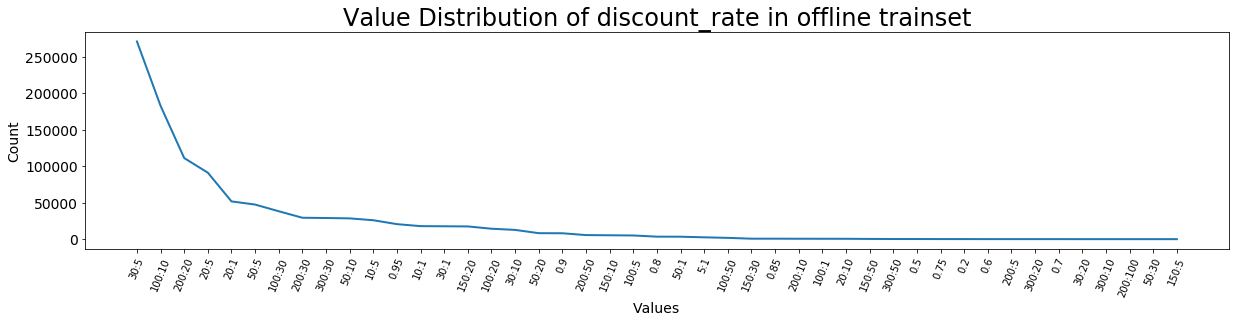

In [51]:
val_dist(df=df_off_train, col_name='discount_rate', df_name='offline trainset', feat_name='discount_rate')

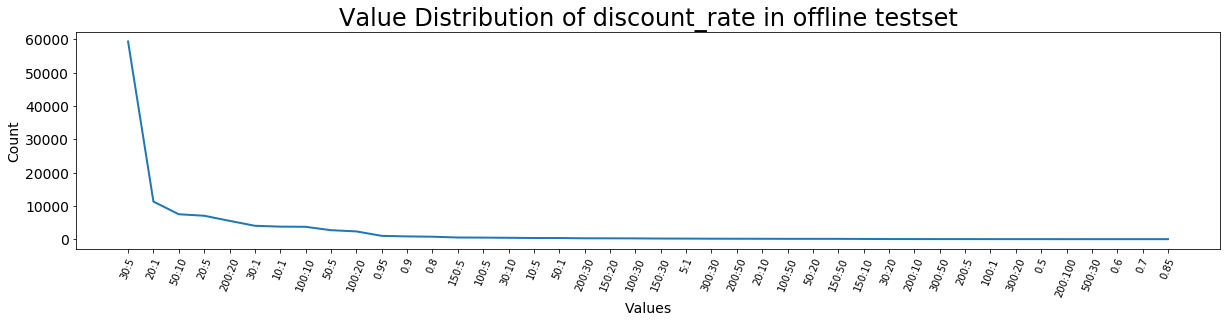

In [52]:
val_dist(df=df_off_test, col_name='discount_rate', df_name='offline testset', feat_name='discount_rate')

# Process Data
> see data_preprocess.py

In [90]:
# format discount rate
def get_discount_rate(s):
    
    s = str(s)
    # case0. no discount
    if s == 'null':
        return -1
    s = s.split(':')
    # case1. this is discount rate like 0.95
    if len(s) == 1:  
        return float(s[0])
    # case2. this is full reduction like 100:10(save 10 over 100)
    else:  
        return 1.0 - float(s[1]) / float(s[0])

In [93]:
# boolean for full reduction
def is_full_reduction(s):
    s = str(s)
    s = s.split(':')
    # case0. this is discount rate like 0.95
    if len(s) == 1:  
        return 0
    # case1. this is full reduction like 100:10(save 10 over 100)
    else:  
        return 1

In [94]:
# condition of full reduction
def get_full_reduction_cond(s):
    s = str(s)
    s = s.split(':')
    # case0. this is discount rate like 0.95
    if len(s) == 1:  
        return -1
    # case1. this is full reduction like 100:10(save 10 over 100)
    else:  
        return int(s[0])

In [95]:
# save of full reduction
def get_full_reduction_save(s):
    s = str(s)
    s = s.split(':')
    # case0. this is discount rate like 0.95
    if len(s) == 1:  
        return -1
    # case1. this is full reduction like 100:10(save 10 over 100)
    else:  
        return int(s[1])

# Analysis of New Data

In [4]:
def read_new_data(file_name, rename_col=None, sample_sz=10000):
    """
    read local data file
    :param file_name: string, format is like xxx.csv
    :param rename_col: list
    :param sample_sz: int, size of sample data, default is 10k
    :return:
    """
    df = pd.read_csv('{0}/{1}'.format(prep_data_dir, file_name), keep_default_na=True)
    if not is_sample:
        pass
    else:  # construct sample data
        idx = list(df.sample(n=sample_sz, random_state=10).index)  # sample is for shuffling
        df = df.iloc[idx, :]

    print('length of df:', len(df))
    return df


In [5]:
# set global args
is_sample = False
original_data_dir = 'data/origin'
prep_data_dir = 'data/prep'

df_train = read_new_data(file_name='ccf_offline_stage1_train.csv')
df_train.head()

length of df: 1754884


,user_id,merchant_id,coupon_id,discount_rate,distance,date_received,date_used,is_full_reduction,full_cond,full_save,days_gap,label
0,1439408,2632,NaN,NaN,0,NaN,20160217.0,0,-1,-1,-1,0
1,1439408,4663,11002.0,0.866667,1,20160528.0,NaN,1,150,20,-1,-1
2,1439408,2632,8591.0,0.950000,0,20160217.0,NaN,1,20,1,-1,-1
3,1439408,2632,1078.0,0.950000,0,20160319.0,NaN,1,20,1,-1,-1
4,1439408,2632,8591.0,0.950000,0,20160613.0,NaN,1,20,1,-1,-1


In [6]:
df_train.describe()

,user_id,merchant_id,coupon_id,discount_rate,distance,date_received,date_used,is_full_reduction,full_cond,full_save,days_gap,label
count,1.754884e+06,1.754884e+06,1.053282e+06,1.053282e+06,1.754884e+06,1.053282e+06,7.769840e+05,1.754884e+06,1.754884e+06,1.754884e+06,1.754884e+06,1.754884e+06
mean,3.689255e+06,4.038808e+03,6.815398e+03,8.443335e-01,2.158577e+00,2.016032e+07,2.016040e+07,5.812407e-01,4.665974e+01,5.807668e+00,-6.212582e-01,-5.268109e-01
std,2.123428e+06,2.435963e+03,4.174276e+03,9.036359e-02,3.470772e+00,1.771416e+02,1.621500e+02,4.933559e-01,6.830349e+01,9.037305e+00,2.414021e+00,5.680412e-01
min,4.000000e+00,1.000000e+00,1.000000e+00,2.000000e-01,-1.000000e+00,2.016010e+07,2.016010e+07,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,1.845052e+06,1.983000e+03,2.840000e+03,8.333333e-01,0.000000e+00,2.016013e+07,2.016031e+07,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
50%,3.694446e+06,3.532000e+03,7.430000e+03,8.500000e-01,0.000000e+00,2.016032e+07,2.016042e+07,1.000000e+00,2.000000e+01,5.000000e+00,-1.000000e+00,-1.000000e+00
75%,5.528759e+06,6.329000e+03,1.032300e+04,9.000000e-01,3.000000e+00,2.016051e+07,2.016052e+07,1.000000e+00,1.000000e+02,1.000000e+01,-1.000000e+00,0.000000e+00
max,7.361032e+06,8.856000e+03,1.404500e+04,9.900000e-01,1.000000e+01,2.016062e+07,2.016063e+07,1.000000e+00,3.000000e+02,1.000000e+02,9.600000e+01,1.000000e+00


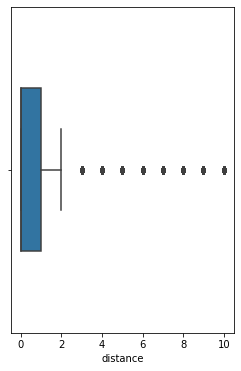

In [9]:
fig = plt.figure(figsize=(4, 6))
sns.boxplot(df_train[(df_train.label>=0) & (df_train.distance>=0)]['distance'],
           orient='v',
           width=0.5)